<h1 style="text-align: center;"><strong>Prediction of Viral Load Suppression Project</strong></h1>

<p style="text-align: center;"><strong>Dègninou Yehadji</strong><br /><span style="color: #0000ff;">TU Dublin, Blanchardstown Campus</span><br /><span style="color: #0000ff;">Dublin 15</span><br /><span style="color: #0000ff;"><em>Email: <a href="mailto:degninou.yehadji@fulbrightmail.org">B00108474@mytudublin.ie</a></em></span> </p>

This is a project conducted using an HIV treatement dataset to predict viral load supression for individuals in the cohort. 

The target variable is Last ART VL Count recoded into a binary variable indicating whether the individual has viral load suppressed or not. The threshold of < 1000 RNA copies/ml is used to define suppressed viral load. 

This Python script is develloped to meet the objective presented above. Specifically, it is intended to: 
- Perform data management tasks on the original dataset 
- Show visualisations of the data using the Python plotting tools
- Develop and evaluate 3 classification models to predict viral load supression 
- Perform cross validation (use k-fold cross validation)
- Perform some searching for optimal values of the hyper or tuning parameters (see GridSearchCV and/or RandomizedSearchCV) in scikit-learn.
- Show the performance of the models by generating classification reports/confusion matrices, ROC curves etc.
- Comment on the process as a whole and in particular on the result of the estimation.

This notebook is dedicated to the data cleaning

## Import required packages 

In [1]:
# Import required packages 

import os
import json

import warnings

import datetime
from datetime import timedelta
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from dython import nominal

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import ExtraTreesClassifier

from ITMO_FS.filters.univariate import reliefF_measure
from ITMO_FS.filters.univariate import information_gain
from ITMO_FS.filters.univariate import gini_index
from ITMO_FS.filters.univariate import f_ratio_measure

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier  
from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.utils import resample

from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from io import StringIO

import missingno as msno 

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import xlrd

## Set working directory and load dataset

In [2]:
os.chdir ("..\..\MCS Thesis\Modeling")
data00 = pd.read_excel('hiv_export_08_2021.xlsx')

In [3]:
data01 = data00.copy()

In [4]:
# Check dataset characteristics
data01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30205 entries, 0 to 30204
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Gender                    30205 non-null  object        
 1   Regiment schedule         30205 non-null  object        
 2   Prior ART                 28725 non-null  object        
 3   Method into ART           25025 non-null  object        
 4   Last ART CD4              18813 non-null  float64       
 5   Last Pre-ART Stage        17659 non-null  float64       
 6   Last Pre-ART CD4          10287 non-null  float64       
 7   Stage at ART Start        24590 non-null  float64       
 8   TB Rx Started             22612 non-null  object        
 9   TPT Outcome               10669 non-null  object        
 10  Age At ART Start          25058 non-null  float64       
 11  Current Age               30205 non-null  int64         
 12  Last ART Prescript

In [5]:
# Frequencies of categorical variables 
train_explor_cat0 = data01.apply(lambda x: x.value_counts(dropna=False)).T.stack()

train_explor_cat0.to_excel('summary_stat_cat0.xlsx', encoding='utf-8-sig', header = True)

# Summary statistics of numérical variables 
train_explor_num0 = data01.describe()
train_explor_num0.to_excel('summary_stat_num0.xlsx', encoding='utf-8-sig')
train_explor_num0.transpose()

C:\Users\MSFuser\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'float', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)
C:\Users\MSFuser\anaconda3\lib\site-packages\pandas\core\indexes\api.py:221: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'float', sort order is undefined for incomparable objects
  result = result.union(other)
C:\Users\MSFuser\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)
C:\Users\MSFuser\anaconda3\lib\site-packages\pandas\core\indexes\api.py:221: RuntimeWarning: '<' not supported between instances of 'float' and 'Timestamp', sort order is undefined for incomparable objects
  result = result.union(other)


,count,mean,std,min,25%,50%,75%,max
Last ART CD4,18813.0,449.062254,305.620302,0.0300,231.0,404.0,606.0,2992.0
Last Pre-ART Stage,17659.0,2.636106,0.833779,1.0000,2.0,3.0,3.0,4.0
Last Pre-ART CD4,10287.0,276.023428,249.533712,0.0000,100.0,216.0,375.0,3000.0
Stage at ART Start,24590.0,2.492029,0.922424,1.0000,2.0,3.0,3.0,4.0
Age At ART Start,25058.0,32.835103,12.748732,0.0000,25.0,32.0,40.0,90.0
Current Age,30205.0,37.628207,13.500802,0.0000,29.0,37.0,46.0,92.0
Baseline CD4,16102.0,298.326089,266.352828,0.0047,117.0,237.5,403.0,3000.0
Duration on ART (months),30181.0,41.535502,49.397465,0.0000,1.0,21.0,66.0,248.0
Last ART VL Count,14252.0,34025.094092,277679.383698,0.0000,1.0,1.0,1.0,9147452.0


## Data cleaning

In [6]:
# Performing some feature ingeniering on the dataset

""" 
Create a binary variable for viral load (VL) suppression (yes/no), based on Last ART VL Count, at a 
threshold of < 1000 RNA copies/ml. 
"""

def VLSuppressed (row):
    if row['Last ART VL Count'] < 1000:
        return "Yes"
    if row['Last ART VL Count'] >= 1000:
        return "No"
    
""" Create a binary variable for patient is on Second Line Treatement (yes/no), based on whether 
Second Line Start Date is available or not. 
""" 
def SecondLine (row):
    if type(row['Second Line Start Date']) is pd.Timestamp:
        return "Yes"
    else:
        return "No"

""" Recode facilities into facility level: 1 for CS and 2 for CMC. 
""" 
"""   
def ftype (row):
    if row['Facility'] == 'CMC Coléah':
        return int(2)
    if row['Facility'] == 'CMC Flamboyants':
        return int(2)
    if row['Facility'] == 'CMC Matam':
        return int(2)       
    if row['Facility'] == 'CMC Minière':
        return int(2)
    if row['Facility'] == 'CS Dabompa':
        return int(1)
    if row['Facility'] == 'CS Gbessia port 1':
        return int(1)
    if row['Facility'] == 'CS Tombolia':
        return int(1)
    if row['Facility'] == 'CS Wanidara':
        return int(1)   
""" 

data01['Second Line Rx'] = data01.apply(lambda row: SecondLine (row), axis=1)
# data01['Facility Level'] = data01.apply(lambda row: ftype (row), axis=1)

""" Recode missing TPT Outcome as No treatement  
"""  
data01['TPT Outcome'].fillna("No treatement", inplace = True)


""" CD4 to be binned into 100-unite ranges. 
"""  

data01['Baseline CD4'] = pd.cut(x=data01['Baseline CD4'], 
                                   bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400,
                                         1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
                                         2800, 2900, 3000], 
                                   labels=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400,
                                         1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
                                         2800, 2900, 3000])

data01['Last Pre-ART CD4'] = pd.cut(x=data01['Last Pre-ART CD4'], 
                                       bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 
                                             1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 
                                             2600, 2700, 2800, 2900, 3000], 
                                       labels=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 
                                             1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 
                                             2600, 2700, 2800, 2900, 3000])

data01['Last ART CD4'] = pd.cut(x=data01['Last ART CD4'], 
                                       bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 
                                             1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 
                                             2600, 2700, 2800, 2900, 3000], 
                                       labels=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 
                                             1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 
                                             2600, 2700, 2800, 2900, 3000])

# Only participants over 18 will be included. Thus, drop participants uner 18
data01.drop(data01[data01['Current Age'] < 18].index, inplace=True)

""" Age to be binned into 5-year age groups. 
"""  
data01['Age At ART Start'] = pd.cut(x=data01['Age At ART Start'], 
                                       bins=[15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 
                                             75, 80, 85, 90, 95, 100], 
                                       labels=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 
                                             75, 80, 85, 90, 95, 100])

data01['Current Age'] = pd.cut(x=data01['Current Age'], 
                                       bins=[15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 
                                             75, 80, 85, 90, 95, 100], 
                                       labels=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 
                                             75, 80, 85, 90, 95, 100])

# Remove record with Duration on ART (months) < 3
data01.drop(data01[data01['Duration on ART (months)'] < 3].index, inplace=True)

""" Duration on ART to be binned into 6-month categories
""" 


data01['Duration on ART (months)'] = pd.cut(x=data01['Duration on ART (months)'], 
                                       bins=[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102,
                                             108, 114, 120, 126, 132, 138, 144, 150], 
                                       labels=[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102,
                                             108, 114, 120, 126, 132, 138, 144, 150])

data01['VL Suppressed'] = data01.apply(lambda row: VLSuppressed (row), axis=1)

# Remove records with missing VL Suppressed
data01 = data01.dropna(subset=['VL Suppressed'])

# Drop columns that are known to be irrelevant according to expert knownledge of the field
# The dataset at this step will be used as working dataset 
data01 = data01.drop(columns=['Second Line Start Date', 'Last ART VL Count'])

In [7]:
data01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13512 entries, 0 to 30204
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Gender                    13512 non-null  object  
 1   Regiment schedule         13512 non-null  object  
 2   Prior ART                 13512 non-null  object  
 3   Method into ART           13512 non-null  object  
 4   Last ART CD4              11144 non-null  category
 5   Last Pre-ART Stage        6899 non-null   float64 
 6   Last Pre-ART CD4          5522 non-null   category
 7   Stage at ART Start        13412 non-null  float64 
 8   TB Rx Started             12205 non-null  object  
 9   TPT Outcome               13512 non-null  object  
 10  Age At ART Start          13352 non-null  category
 11  Current Age               13512 non-null  category
 12  Last ART Prescription     13512 non-null  object  
 13  Facility                  13512 non-null  obje

In [8]:
data02 = data01.copy()

In [9]:
# Split the clean dataset into train and test sets
data_train, data_test = train_test_split(data02, test_size=0.3, random_state=5) 

data_train = data_train.reset_index()
data_train = data_train.drop(['index'], axis = 1)

data_test = data_test.reset_index()
data_test = data_test.drop(['index'], axis = 1)

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Gender                    9458 non-null   object  
 1   Regiment schedule         9458 non-null   object  
 2   Prior ART                 9458 non-null   object  
 3   Method into ART           9458 non-null   object  
 4   Last ART CD4              7788 non-null   category
 5   Last Pre-ART Stage        4802 non-null   float64 
 6   Last Pre-ART CD4          3881 non-null   category
 7   Stage at ART Start        9376 non-null   float64 
 8   TB Rx Started             8554 non-null   object  
 9   TPT Outcome               9458 non-null   object  
 10  Age At ART Start          9343 non-null   category
 11  Current Age               9458 non-null   category
 12  Last ART Prescription     9458 non-null   object  
 13  Facility                  9458 non-null   object

In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 0 to 4053
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Gender                    4054 non-null   object  
 1   Regiment schedule         4054 non-null   object  
 2   Prior ART                 4054 non-null   object  
 3   Method into ART           4054 non-null   object  
 4   Last ART CD4              3356 non-null   category
 5   Last Pre-ART Stage        2097 non-null   float64 
 6   Last Pre-ART CD4          1641 non-null   category
 7   Stage at ART Start        4036 non-null   float64 
 8   TB Rx Started             3651 non-null   object  
 9   TPT Outcome               4054 non-null   object  
 10  Age At ART Start          4009 non-null   category
 11  Current Age               4054 non-null   category
 12  Last ART Prescription     4054 non-null   object  
 13  Facility                  4054 non-null   object

In [12]:
# Frequencies of categorical variables 
# train_explor_cat1 = data_train.apply(lambda x: x.value_counts(dropna=False))

train_explor_cat1 = pd.concat([data_train[column].value_counts(dropna=False) \
                                for column in data_train], axis = 1).T.stack()

train_explor_cat1.to_excel('summary_stat_cat1.xlsx', encoding='utf-8-sig', header = True)

In [13]:
# Summary statistics of numérical variables 
train_explor_num1 = data_train.describe()
train_explor_num1.to_excel('summary_stat_num1.xlsx', encoding='utf-8-sig')
train_explor_num1.transpose()

,count,mean,std,min,25%,50%,75%,max
Last Pre-ART Stage,4802.0,2.670346,0.784557,1.0,2.0,3.0,3.0,4.0
Stage at ART Start,9376.0,2.527090,0.890909,1.0,2.0,3.0,3.0,4.0


In [14]:
gender = pd.crosstab(data_train['Gender'], data_train['VL Suppressed'], margins=True, dropna = False)
regiments = pd.crosstab(data_train['Regiment schedule'], data_train['VL Suppressed'], margins=True, dropna = False)
priorart = pd.crosstab(data_train['Prior ART'], data_train['VL Suppressed'], margins=True, dropna = False)
methodint = pd.crosstab(data_train['Method into ART'], data_train['VL Suppressed'], margins=True, dropna = False)
baselinec = pd.crosstab(data_train['Baseline CD4'], data_train['VL Suppressed'], margins=True, dropna = False)
lastprecd1 = pd.crosstab(data_train['Last Pre-ART CD4'], data_train['VL Suppressed'], margins=True, dropna = False)
lastartc = pd.crosstab(data_train['Last ART CD4'], data_train['VL Suppressed'], margins=True, dropna = False)
lastprecd2 = pd.crosstab(data_train['Last Pre-ART Stage'], data_train['VL Suppressed'], margins=True, dropna = False)
stageata = pd.crosstab(data_train['Stage at ART Start'], data_train['VL Suppressed'], margins=True, dropna = False)
tbrxstar = pd.crosstab(data_train['TB Rx Started'], data_train['VL Suppressed'], margins=True, dropna = False)
tptoutcom = pd.crosstab(data_train['TPT Outcome'], data_train['VL Suppressed'], margins=True, dropna = False)
ageatart = pd.crosstab(data_train['Age At ART Start'], data_train['VL Suppressed'], margins=True, dropna = False)
currentag = pd.crosstab(data_train['Current Age'], data_train['VL Suppressed'], margins=True, dropna = False)
regimenat = pd.crosstab(data_train['Regimen At Baseline'], data_train['VL Suppressed'], margins=True, dropna = False)
lastartp = pd.crosstab(data_train['Last ART Prescription'], data_train['VL Suppressed'], margins=True, dropna = False)
tbstatus = pd.crosstab(data_train['TB Status At Last Visit'], data_train['VL Suppressed'], margins=True, 
                       dropna = False)
cptatart = pd.crosstab(data_train['CPT at ART Start'], data_train['VL Suppressed'], margins=True, dropna = False)
durationo = pd.crosstab(data_train['Duration on ART (months)'], data_train['VL Suppressed'], margins=True, 
                        dropna = False)
secondlin = pd.crosstab(data_train['Second Line Rx'], data_train['VL Suppressed'], margins=True, dropna = False)
facility = pd.crosstab(data_train['Facility'], data_train['VL Suppressed'], margins=True, dropna = False)

frames = [gender, regiments, priorart, methodint, baselinec, lastprecd1, lastartc, lastprecd2, stageata,
          tbrxstar, tptoutcom, ageatart, currentag, regimenat, lastartp, tbstatus, cptatart, durationo,
          secondlin, facility]

freqbyvl = pd.concat(frames)

freqbyvl.to_excel('summary_freq_by_VLa.xlsx', encoding='utf-8-sig', header = True)

## Visualization of missing values in the dataset

<AxesSubplot:>

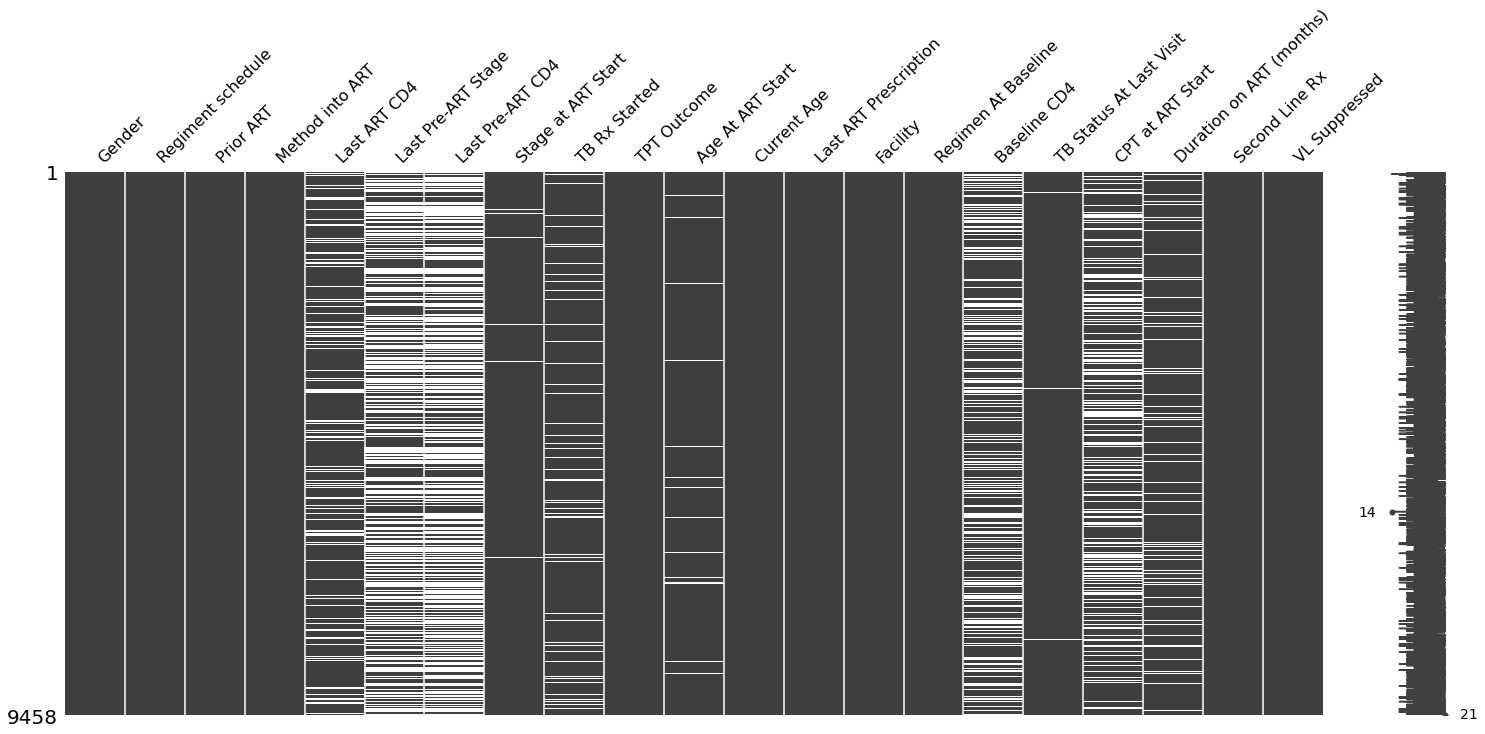

In [15]:
# Matrix visualization of missing values 
msno.matrix(data_train) 

In [16]:
# Save raw training set

data_train.to_excel('data_train_raw.xlsx', encoding='utf-8-sig', header = True)

## Data transformation

In [17]:
# Recode variables 

def cd4d (row):
    if row['Last ART CD4'] == "":
        return ""    
    if row['Last ART CD4'] == 100:
        return 100
    if row['Last ART CD4'] == 200:
        return 200
    if row['Last ART CD4'] == 300:
        return 300
    if row['Last ART CD4'] == 400:
        return 400
    if row['Last ART CD4'] == 500:
        return 500  
    if ((row['Last ART CD4'] == 600) or (row['Last ART CD4'] == 700) or\
        (row['Last ART CD4'] == 800) or (row['Last ART CD4'] == 900) or\
        (row['Last ART CD4'] == 1000) or (row['Last ART CD4'] == 1100) or\
        (row['Last ART CD4'] == 1200) or (row['Last ART CD4'] == 1300) or\
        (row['Last ART CD4'] == 1400) or (row['Last ART CD4'] == 1500) or\
        (row['Last ART CD4'] == 1600) or (row['Last ART CD4'] == 1700) or\
        (row['Last ART CD4'] == 1800) or (row['Last ART CD4'] == 1900) or\
        (row['Last ART CD4'] == 2000) or (row['Last ART CD4'] == 2100) or\
        (row['Last ART CD4'] == 2200) or (row['Last ART CD4'] == 2300) or\
        (row['Last ART CD4'] == 2400) or (row['Last ART CD4'] == 2500) or\
        (row['Last ART CD4'] == 2600) or (row['Last ART CD4'] == 2700) or\
        (row['Last ART CD4'] == 2800) or (row['Last ART CD4'] == 2900) or\
        (row['Last ART CD4'] == 3000)):
        return 600

def cd4e (row):
    if row['Last Pre-ART CD4'] == "":
        return ""
    if row['Last Pre-ART CD4'] == 100:
        return 100
    if row['Last Pre-ART CD4'] == 200:
        return 200
    if row['Last Pre-ART CD4'] == 300:
        return 300
    if row['Last Pre-ART CD4'] == 400:
        return 400
    if row['Last Pre-ART CD4'] == 500:
        return 500        
    if ((row['Last Pre-ART CD4'] == 600) or (row['Last Pre-ART CD4'] == 700) or\
        (row['Last Pre-ART CD4'] == 800) or (row['Last Pre-ART CD4'] == 900) or\
        (row['Last Pre-ART CD4'] == 1000) or (row['Last Pre-ART CD4'] == 1100) or\
        (row['Last Pre-ART CD4'] == 1200) or (row['Last Pre-ART CD4'] == 1300) or\
        (row['Last Pre-ART CD4'] == 1400) or (row['Last Pre-ART CD4'] == 1500) or\
        (row['Last Pre-ART CD4'] == 1600) or (row['Last Pre-ART CD4'] == 1700) or\
        (row['Last Pre-ART CD4'] == 1800) or (row['Last Pre-ART CD4'] == 1900) or\
        (row['Last Pre-ART CD4'] == 2000) or (row['Last Pre-ART CD4'] == 2100) or\
        (row['Last Pre-ART CD4'] == 2200) or (row['Last Pre-ART CD4'] == 2300) or\
        (row['Last Pre-ART CD4'] == 2400) or (row['Last Pre-ART CD4'] == 2500) or\
        (row['Last Pre-ART CD4'] == 2600) or (row['Last Pre-ART CD4'] == 2700) or\
        (row['Last Pre-ART CD4'] == 2800) or (row['Last Pre-ART CD4'] == 2900) or\
        (row['Last Pre-ART CD4'] == 3000)):
        return 600
    
def cd4f (row):
    if row['Baseline CD4'] == "":
        return ""
    if row['Baseline CD4'] == 100:
        return 100
    if row['Baseline CD4'] == 200:
        return 200
    if row['Baseline CD4'] == 300:
        return 300
    if row['Baseline CD4'] == 400:
        return 400
    if row['Baseline CD4'] == 500:
        return 500        
    if ((row['Baseline CD4'] == 600) or (row['Baseline CD4'] == 700) or\
        (row['Baseline CD4'] == 800) or (row['Baseline CD4'] == 900) or\
        (row['Baseline CD4'] == 1000) or (row['Baseline CD4'] == 1100) or\
        (row['Baseline CD4'] == 1200) or (row['Baseline CD4'] == 1300) or\
        (row['Baseline CD4'] == 1400) or (row['Baseline CD4'] == 1500) or\
        (row['Baseline CD4'] == 1600) or (row['Baseline CD4'] == 1700) or\
        (row['Baseline CD4'] == 1800) or (row['Baseline CD4'] == 1900) or\
        (row['Baseline CD4'] == 2000) or (row['Baseline CD4'] == 2100) or\
        (row['Baseline CD4'] == 2200) or (row['Baseline CD4'] == 2300) or\
        (row['Baseline CD4'] == 2400) or (row['Baseline CD4'] == 2500) or\
        (row['Baseline CD4'] == 2600) or (row['Baseline CD4'] == 2700) or\
        (row['Baseline CD4'] == 2800) or (row['Baseline CD4'] == 2900) or\
        (row['Baseline CD4'] == 3000)):
        return 600

def tpt (row):
    if row['TPT Outcome'] == 'Rx completed':
        return 'Rx completed'
    if row['TPT Outcome'] == 'No treatement':
        return 'No treatement'
    if row['TPT Outcome'] == np.nan:
        return np.nan
    else: 
        return 'Other'
    
def regimen1 (row):
    if row['Regimen At Baseline'] == '1T3E':
        return '1T3E'
    if row['Regimen At Baseline'] == '1S3N':
        return '1S3N'
    if row['Regimen At Baseline'] == '1Z3N':
        return '1Z3N'
    if row['Regimen At Baseline'] == '1T3N':
        return '1T3N'
    if row['Regimen At Baseline'] == '1S3E':
        return '1S3E'
    if row['Regimen At Baseline'] == np.nan:
        return np.nan
    else:
        return 'Other'
    
def regimen2 (row):
    if row['Last ART Prescription'] == '1T3E':
        return '1T3E'
    if row['Last ART Prescription'] == '1T3O':
        return '1T3O'
    if row['Last ART Prescription'] == '2Z3L':
        return '2Z3L'
    if row['Last ART Prescription'] == '1Z3N':
        return '1Z3N'
    if row['Last ART Prescription'] == '2T3L':
        return '2T3L'
    if row['Last ART Prescription'] == np.nan:
        return np.nan
    else: 
        return 'Other'

def tbstatus (row):
    if row['TB Status At Last Visit'] == 'No symptoms':
        return 'No symptoms'
    if row['TB Status At Last Visit'] == 'Not Screened':
        return 'Not Screened'
    if row['TB Status At Last Visit'] == 'Screening Unknown':
        return 'Screening Unknown'
    if row['TB Status At Last Visit'] == np.nan:
        return np.nan
    else:
        return 'Other'

def age1 (row):
    if row['Age At ART Start'] == "":
        return ""
    if row['Age At ART Start'] == 20:
        return 20
    if row['Age At ART Start'] == 25:
        return 25
    if row['Age At ART Start'] == 30:
        return 30
    if row['Age At ART Start'] == 35:
        return 35
    if row['Age At ART Start'] == 40:
        return 40
    if row['Age At ART Start'] == 45:
        return 45
    if row['Age At ART Start'] == 50:
        return 50
    if row['Age At ART Start'] == 55:
        return 55
    if ((row['Age At ART Start'] == 60) or (row['Age At ART Start'] == 65) or\
        (row['Age At ART Start'] == 70) or (row['Age At ART Start'] == 75) or\
        (row['Age At ART Start'] == 80) or (row['Age At ART Start'] == 85) or\
        (row['Age At ART Start'] == 90) or (row['Age At ART Start'] == 95) or\
        (row['Age At ART Start'] == 100)):
        return 60

def age2 (row):
    if row['Current Age'] == "":
        return ""
    if row['Current Age'] == 20:
        return 20
    if row['Current Age'] == 25:
        return 25
    if row['Current Age'] == 30:
        return 30
    if row['Current Age'] == 35:
        return 35
    if row['Current Age'] == 40:
        return 40
    if row['Current Age'] == 45:
        return 45
    if row['Current Age'] == 50:
        return 50
    if row['Current Age'] == 55:
        return 55
    if ((row['Current Age'] == 60) or (row['Current Age'] == 65) or (row['Current Age'] == 70)\
        or (row['Current Age'] == 75) or (row['Current Age'] == 80) or\
        (row['Current Age'] == 85) or (row['Current Age'] == 90) or\
        (row['Current Age'] == 95) or (row['Current Age'] == 100)):
        return 60

data_train['Last ART CD4'] = data_train.apply(lambda row: cd4d (row), axis=1)
data_test['Last ART CD4'] = data_test.apply(lambda row: cd4d (row), axis=1)

data_train['Last Pre-ART CD4'] = data_train.apply(lambda row: cd4e (row), axis=1)
data_test['Last Pre-ART CD4'] = data_test.apply(lambda row: cd4e (row), axis=1)

data_train['Baseline CD4'] = data_train.apply(lambda row: cd4f (row), axis=1)
data_test['Baseline CD4'] = data_test.apply(lambda row: cd4f (row), axis=1)

data_train['TPT Outcome'] = data_train.apply(lambda row: tpt (row), axis=1)
data_test['TPT Outcome'] = data_test.apply(lambda row: tpt (row), axis=1)

data_train['Regimen At Baseline'] = data_train.apply(lambda row: regimen1 (row), axis=1)
data_test['Regimen At Baseline'] = data_test.apply(lambda row: regimen1 (row), axis=1)

data_train['Last ART Prescription'] = data_train.apply(lambda row: regimen2 (row), axis=1)
data_test['Last ART Prescription'] = data_test.apply(lambda row: regimen2 (row), axis=1)

data_train['TB Status At Last Visit'] = data_train.apply(lambda row: tbstatus (row), axis=1)
data_test['TB Status At Last Visit'] = data_test.apply(lambda row: tbstatus (row), axis=1)

data_train['Age At ART Start'] = data_train.apply(lambda row: age1 (row), axis=1)
data_test['Age At ART Start'] = data_test.apply(lambda row: age1 (row), axis=1)

data_train['Current Age'] = data_train.apply(lambda row: age2 (row), axis=1)
data_test['Current Age'] = data_test.apply(lambda row: age2 (row), axis=1)

In [18]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Gender                    9458 non-null   object  
 1   Regiment schedule         9458 non-null   object  
 2   Prior ART                 9458 non-null   object  
 3   Method into ART           9458 non-null   object  
 4   Last ART CD4              7788 non-null   float64 
 5   Last Pre-ART Stage        4802 non-null   float64 
 6   Last Pre-ART CD4          3881 non-null   float64 
 7   Stage at ART Start        9376 non-null   float64 
 8   TB Rx Started             8554 non-null   object  
 9   TPT Outcome               9458 non-null   object  
 10  Age At ART Start          9343 non-null   float64 
 11  Current Age               9458 non-null   int64   
 12  Last ART Prescription     9458 non-null   object  
 13  Facility                  9458 non-null   object

<AxesSubplot:>

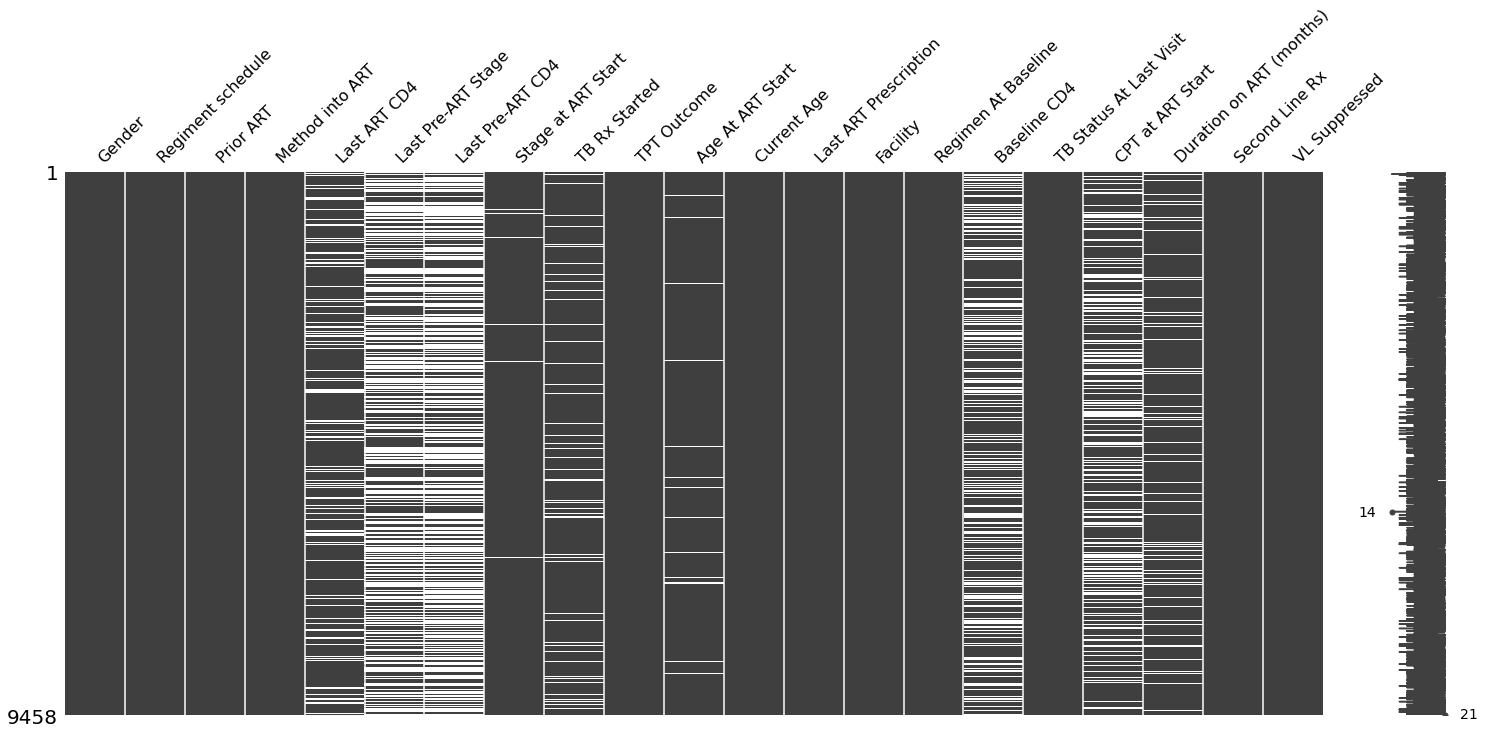

In [19]:
# Matrix visualization of missing values 
msno.matrix(data_train) 

In [20]:
data_train.to_excel('data_train_recod.xlsx', encoding='utf-8-sig', header = True)

In [21]:
# Create a subset with categorical variables only - Test training set
train_cat = data_train[['Gender', 'Regiment schedule', 'Prior ART', 'Method into ART', 'TB Rx Started', 
                        'TPT Outcome', 'Regimen At Baseline', 'Last ART Prescription', 'Facility', 
                        'TB Status At Last Visit', 'CPT at ART Start', 'Second Line Rx', 'VL Suppressed']]

train_cat = pd.get_dummies(train_cat) 
train_cat = train_cat.drop(columns=['Gender_Female', 'Method into ART_Transfered', 'Prior ART_Non-naive',
                                    'TB Rx Started_No', 'CPT at ART Start_No', 'VL Suppressed_No', 
                                    'Second Line Rx_No'])

# Create a subset with numerical variables only - Test training set 
train_num = data_train[['Baseline CD4', 'Last Pre-ART CD4', 'Last ART CD4', 'Last Pre-ART Stage',
                        'Stage at ART Start', 'Age At ART Start', 'Current Age',
                        'Duration on ART (months)']]

#Fill the remaining missing values with KNN imputation 
imputer = KNNImputer(n_neighbors=5)
train_num_full = imputer.fit_transform(train_num)

train_num_full = pd.DataFrame(train_num_full, 
                                   columns=['Baseline CD4', 'Last Pre-ART CD4', 'Last ART CD4', 'Last Pre-ART Stage',
                                            'Stage at ART Start', 'Age At ART Start', 'Current Age',
                                            'Duration on ART (months)'])

data_train = pd.merge(train_cat, train_num_full, left_index=True, right_index=True)
data_train = data_train.round(0)

In [22]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Gender_Male                                9458 non-null   uint8  
 1   Regiment schedule_3-Month                  9458 non-null   uint8  
 2   Regiment schedule_6-Month                  9458 non-null   uint8  
 3   Regiment schedule_Regular                  9458 non-null   uint8  
 4   Prior ART_Naive                            9458 non-null   uint8  
 5   Method into ART_New                        9458 non-null   uint8  
 6   TB Rx Started_Yes                          9458 non-null   uint8  
 7   TPT Outcome_No treatement                  9458 non-null   uint8  
 8   TPT Outcome_Other                          9458 non-null   uint8  
 9   TPT Outcome_Rx completed                   9458 non-null   uint8  
 10  Regimen At Baseline_1S3E

In [23]:
# Create a subset with categorcial variables only - Test set
test_cat = data_test[['Gender', 'Regiment schedule', 'Prior ART', 'Method into ART', 'TB Rx Started', 
                        'TPT Outcome', 'Regimen At Baseline', 'Last ART Prescription', 'Facility', 
                        'TB Status At Last Visit', 'CPT at ART Start', 'Second Line Rx', 'VL Suppressed']]

test_cat = pd.get_dummies(test_cat) 
test_cat = test_cat.drop(columns=['Gender_Female', 'Method into ART_Transfered', 'Prior ART_Non-naive',
                                  'TB Rx Started_No', 'CPT at ART Start_No', 'VL Suppressed_No',
                                  'Second Line Rx_No'])

# Create a subset with numerical variables only - Test set 
test_num = data_test[['Baseline CD4', 'Last Pre-ART CD4', 'Last ART CD4', 'Last Pre-ART Stage',
                        'Stage at ART Start', 'Age At ART Start', 'Current Age',
                        'Duration on ART (months)']]

#Fill the remaining missing values with KNN imputation 
imputer = KNNImputer(n_neighbors=5)
test_num_full = imputer.fit_transform(test_num)

test_num_full = pd.DataFrame(test_num_full, 
                             columns=['Baseline CD4', 'Last Pre-ART CD4', 'Last ART CD4', 'Last Pre-ART Stage',
                                      'Stage at ART Start', 'Age At ART Start', 'Current Age',
                                      'Duration on ART (months)'])
data_test = pd.merge(test_cat, test_num_full, left_index=True, right_index=True)
data_test = data_test.round(0)

In [24]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 0 to 4053
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Gender_Male                                4054 non-null   uint8  
 1   Regiment schedule_3-Month                  4054 non-null   uint8  
 2   Regiment schedule_6-Month                  4054 non-null   uint8  
 3   Regiment schedule_Regular                  4054 non-null   uint8  
 4   Prior ART_Naive                            4054 non-null   uint8  
 5   Method into ART_New                        4054 non-null   uint8  
 6   TB Rx Started_Yes                          4054 non-null   uint8  
 7   TPT Outcome_No treatement                  4054 non-null   uint8  
 8   TPT Outcome_Other                          4054 non-null   uint8  
 9   TPT Outcome_Rx completed                   4054 non-null   uint8  
 10  Regimen At Baseline_1S3E

In [25]:
# Frequencies of categorical variables 
train_explor_cat2 = data_train.apply(lambda x: x.value_counts(dropna=False)).T.stack()

train_explor_cat2.to_excel('sumary_stat_cat2_notoversampled.xlsx', encoding='utf-8-sig', header = True)

## Correction of class imbalance

In [26]:
# Separate majority and minority classes
train_major = data_train[data_train['VL Suppressed_Yes']==1]
train_minor = data_train[data_train['VL Suppressed_Yes']==0]

# Oversample minority class
train_minor_sampled = resample(train_minor, 
                             replace=True,    # sample with replacement
                             n_samples=8392,  # to match majority class
                             random_state=5) # reproducible results

# Combine majority class with upsampled minority class
data_train = pd.concat([train_major, train_minor_sampled])

In [27]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16793 entries, 0 to 6258
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Gender_Male                                16793 non-null  uint8  
 1   Regiment schedule_3-Month                  16793 non-null  uint8  
 2   Regiment schedule_6-Month                  16793 non-null  uint8  
 3   Regiment schedule_Regular                  16793 non-null  uint8  
 4   Prior ART_Naive                            16793 non-null  uint8  
 5   Method into ART_New                        16793 non-null  uint8  
 6   TB Rx Started_Yes                          16793 non-null  uint8  
 7   TPT Outcome_No treatement                  16793 non-null  uint8  
 8   TPT Outcome_Other                          16793 non-null  uint8  
 9   TPT Outcome_Rx completed                   16793 non-null  uint8  
 10  Regimen At Baseline_1S3

In [28]:
# Frequencies of categorical variables 
train_explor_cat3 = data_train.apply(lambda x: x.value_counts(dropna=False)).T.stack()

train_explor_cat3.to_excel('sumary_stat_cat2_oversampled.xlsx', encoding='utf-8-sig', header = True)

## Feature selection 

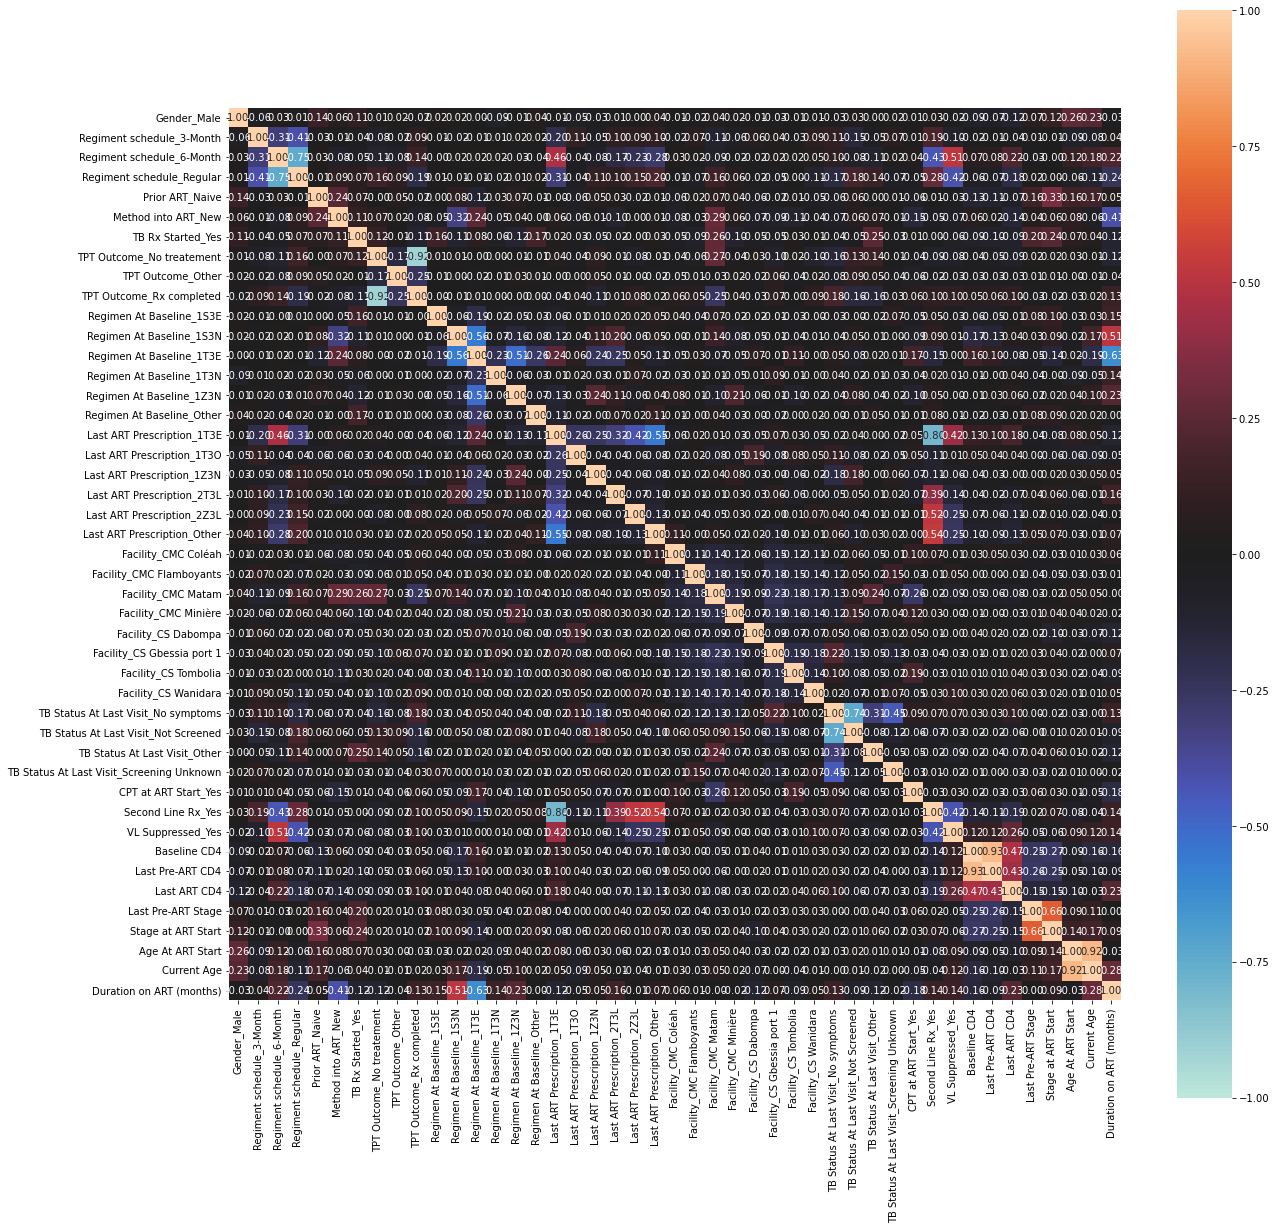

In [29]:
assoc2 = nominal.associations(data_train, nominal_columns='auto', figsize=(20, 20))['corr']

In [30]:
assoc2.to_excel(r'correlation.xlsx', sheet_name='correlation')

In [31]:
# Create a subset with potential predictors - Training set
x_train = data_train[['Gender_Male',
'Regiment schedule_3-Month',
'Regiment schedule_6-Month',
'Regiment schedule_Regular',
'Prior ART_Naive',
'Method into ART_New',
'TB Rx Started_Yes',
'TPT Outcome_No treatement',
'TPT Outcome_Other',
'TPT Outcome_Rx completed',
'Regimen At Baseline_1S3E',
'Regimen At Baseline_1S3N',
'Regimen At Baseline_1T3E',
'Regimen At Baseline_1T3N',
'Regimen At Baseline_1Z3N',
'Regimen At Baseline_Other',
'Last ART Prescription_1T3E',
'Last ART Prescription_1T3O',
'Last ART Prescription_1Z3N',
'Last ART Prescription_2T3L',
'Last ART Prescription_2Z3L',
'Last ART Prescription_Other',
'Facility_CMC Coléah',
'Facility_CMC Flamboyants',
'Facility_CMC Matam',
'Facility_CMC Minière',
'Facility_CS Dabompa',
'Facility_CS Gbessia port 1',
'Facility_CS Tombolia',
'Facility_CS Wanidara',
'TB Status At Last Visit_No symptoms',
'TB Status At Last Visit_Not Screened',
'TB Status At Last Visit_Other',
'TB Status At Last Visit_Screening Unknown',
'CPT at ART Start_Yes',
'Second Line Rx_Yes',
'Baseline CD4',
'Last Pre-ART CD4',
'Last ART CD4',
'Last Pre-ART Stage',
'Stage at ART Start',
'Age At ART Start',
'Current Age',
'Duration on ART (months)']]

y_train = data_train[['VL Suppressed_Yes']]

x_train = x_train.to_numpy()
x_train = x_train.astype(int)

y_train = y_train.to_numpy()
y_train = y_train.astype(int)

In [32]:
# In[ ]:

# Feature selection using gini index
gini_scores = gini_index(x_train, y_train)
gini_scores_df = pd.DataFrame(gini_scores)

gini_scores_df.to_excel('gini_scores.xlsx', encoding='utf-8-sig')

In [33]:
# In[ ]:

# Feature selection using f_ratio_measure
f_scores = f_ratio_measure(x_train, y_train)
f_scores_df = pd.DataFrame(f_scores)

f_scores_df.to_excel('f_scores.xlsx', encoding='utf-8-sig') 

In [34]:
data_train.to_excel('data_train_clean.xlsx', index = False)
data_test.to_excel('data_test_clean.xlsx', index = False)

End of the data cleaning !